<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_naranja@4x.png?raw=true" alt="esquema" />
</div>


# Laboratorio EDA y Gestión de Nulos

AutoRenew, una empresa líder en la venta de coches de segunda mano, te ha contratado para desarrollar un modelo predictivo que estime el precio de los vehículos usados. Este modelo ayudará a la empresa a mejorar sus estrategias de ventas, marketing y optimización del inventario. Para ello, cuentas con un conjunto de datos que contiene información detallada sobre diversas características de los coches usados. Sin embargo, como es común en conjuntos de datos reales, encontrarás valores nulos y necesitarás realizar un análisis exploratorio para identificar patrones, correlaciones y posibles anomalías.

 En este laboratorio, tu tarea es realizar un análisis exploratorio de los datos (EDA) y gestionar los valores nulos que encuentres. Este es solo el primer paso de un proyecto que se desarrollará durante toda la semana, en el que usarás este mismo conjunto de datos para practicar diferentes fases del preprocesamiento.

**Columnas del conjunto de datos:**

- **dateCrawled**: Fecha y hora en que se recolectaron los datos del coche.

- **name**: Nombre del anuncio, generalmente incluye la marca y el modelo del coche.

- **seller**: Tipo de vendedor (particular o concesionario).

- **offerType**: Tipo de oferta (venta o subasta).

- **price**: Precio del coche en la moneda local.

- **abtest**: Campo utilizado para pruebas A/B, indicando diferentes versiones del sitio web o anuncio.

- **vehicleType**: Tipo de vehículo (sedán, SUV, hatchback, etc.).

- **yearOfRegistration**: Año de registro del coche.

- **gearbox**: Tipo de caja de cambios (manual o automática).

- **powerCV**: Potencia del coche en caballos de vapor (CV).

- **model**: Modelo específico del coche.

- **kilometer**: Kilometraje total del coche.

- **monthOfRegistration**: Mes de registro del coche.

- **fuelType**: Tipo de combustible (gasolina, diésel, eléctrico, etc.).

- **brand**: Marca del coche.

- **notRepairedDamage**: Indica si el coche tiene daños no reparados.

- **dateCreated**: Fecha de creación del anuncio.

- **nrOfPictures**: Número de fotos en el anuncio.

- **postalCode**: Código postal de la ubicación del coche.

- **lastSeen**: Última fecha y hora en que el anuncio fue visto.

**Instrucciones:**

1. **Análisis Exploratorio de Datos (EDA):** Explora el conjunto de datos para familiarizarte con las diferentes características de los coches. Utiliza gráficos y estadísticas descriptivas para identificar patrones, tendencias y posibles anomalías.
   
2. **Gestión de Valores Nulos:** Identifica las columnas que contienen valores nulos y aplica las técnicas adecuadas para manejarlos. Esto podría incluir la imputación de valores, eliminación de filas o columnas, o cualquier otra estrategia que consideres apropiada.

**Nota:** Este laboratorio es el primer paso de una serie de actividades que realizarás esta semana utilizando el mismo conjunto de datos. Asegúrate de documentar bien tu trabajo, ya que lo utilizarás como base para los siguientes ejercicios.


---

In [95]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd

# Otros objetivos
# -----------------------------------------------------------------------
import math

# Gráficos
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

# Ignorar warings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")

from src.soporte import *

### Lectura de datos

In [96]:
df = pd.read_csv('datos/autorenew.csv')

### Fechas

Las fechas `dateCrawled`, `dateCreated` y `lastSeen` realmente no nos aportan gran cosa. Vamos a ver si hay ofertas muy antiguas

In [97]:
df['dateCrawled'] = pd.to_datetime(df['dateCrawled'])
df['dateCreated'] = pd.to_datetime(df['dateCreated'])
df['lastSeen'] = pd.to_datetime(df['lastSeen'])

In [98]:
df['dateCrawled'].dt.year.unique()

array([2016], dtype=int32)

In [99]:
df['dateCreated'].dt.year.unique()

array([2016, 2015, 2014], dtype=int32)

In [100]:
df['lastSeen'].dt.year.unique()

array([2016], dtype=int32)

Vemos que las fechas están concentradas en el año 2016, aunque algunos anuncios son de 2014 o 2015. Esta información nos sirve para filtar modelos de años posteriores, ya que no deberían existir en 2016. Por el resto estas columnas no nos aportan valor por lo que ahora podemos eliminarlas.

In [101]:
df.drop(columns=['dateCrawled', 'dateCreated', 'lastSeen'], inplace=True)

### Datos numéricos

In [102]:
# Describe de datos numéricos
df.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
price,371528.0,17295.14,3587953.74,0.0,1150.0,2950.0,7200.0,2.147484e+09
yearOfRegistration,371528.0,2004.58,92.87,1000.0,1999.0,2003.0,2008.0,9.999000e+03
powerCV,371528.0,113.97,189.52,0.0,69.0,104.0,148.0,1.972600e+04
kilometer,371528.0,125618.69,40112.34,5000.0,125000.0,150000.0,150000.0,1.500000e+05
monthOfRegistration,371528.0,5.73,3.71,0.0,3.0,6.0,9.0,1.200000e+01
nrOfPictures,371528.0,0.00,0.00,0.0,0.0,0.0,0.0,0.000000e+00
postalCode,371528.0,50820.67,25799.08,1067.0,30459.0,49610.0,71546.0,9.999800e+04


Insight rápidos:

* `price`: El mínimo de precio es 0, lo cual es extraño ya que un coche gratis no tiene sentido. La media es mucho mayo que la mediana lo cual puede ser indicativo de gran cantidad de outliers que podrían corresponder a vehículos de lujo. Sin embargo, el máximo de precio es del orden de 1e9 (mil millones) lo cual es imposible. Esto sugiere que diferentes divisas pueden estar siendo entremezcladas, aunque no vamos a considerar estos ya que no tenemos información sobre esto.

* `yearOfRegistration`: El mínimo es 1000, lo cual no tiene mucho sentido ya que antes de 1900 no existían los coches (y no se suelen vender vehículos tan antiguos). También parece haber valores de 9999, lo cual puede ser un error en la entrada de datos.

* `powerCV`: El mínimo no puede ser 0, y el máximo es imposible que llegue a 19700, ya que los coches de competición más potentes suelen rondar los 1000CV como máximo. El resto de estadísticos parecen razonables (de 50 a 150 CV es lo habitual).

* `kilometer`: En este caso los valores parecen razonables. Además la media y la mediana tienen valores similares.

* `monthOfregistration`: Realmente esto es una variable categórica. Solamente destaca el mínimo, 0, que es imposible. Por el resto, valores entre 1 y 12 tienen sentido.

* `nrOfPictures`: Todas las entradas son 0.

* `PostalCode`: Poco que decir aquí, son códigos postales. Se podría considerar categórica. Al menos vemos que no hay valroes negativos.

---

En `price` convertimos los valores menores de 250 a nulo. Consideramos que es el umbral para el que un coche puede ser vendido a ese precio, por debajo de esto lo tomamos como un error

In [103]:
df['price'] = df['price'].apply(lambda x: np.nan if (x < 250 or x > 5e6) else x)

En `yearOfRegistration` convertimos a nulos los años anteriores a 1900 y los posteriores a 2016, que no tienen sentido. Su distribución (analizada previamente en este proceso iterativo) revela que conviene tratarla como numérica, aunque se puede catalogar como categórica.

In [104]:
df['yearOfRegistration'] = df['yearOfRegistration'].apply(lambda x: np.nan if (x < 1900 or x > 2016) else x)

En cuanto a `powerCV` valores de menos de 10 CV no tienen sentido, ya que serían casi correspondientes a ciclomotores o incluso bicicletas elécticas. Los camiones más potentes no suelen exceder los 1200 CV por lo que dejaremos el límite superior en 1300.

In [105]:
df['powerCV'] = df['powerCV'].apply(lambda x: np.nan if (x < 10 or x > 1300) else x)

El `monthOfRegistration` convertiremos los 0 a nulos. Además lo convertiremos a variable categórica

In [106]:
df['monthOfRegistration'] = df['monthOfRegistration'].apply(lambda x: np.nan if x == 0 else x).astype(object)

El `nrOfPictures` solo tiene nulos y no nos aporta nada por lo que nos quitamos esa columna

In [107]:
df.drop(columns='nrOfPictures', inplace=True)

El `postalcode` simplemente lo eliminamos porque no sabemos de dónde son. Podrían ser de España pero España solo llega a 52000, y para el jaleo que es poner el resto desconocidos no vale la pena.

In [108]:
df.drop(columns='postalCode', inplace=True)

Nos queda así:

In [109]:
# Describe de datos numéricos
df.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
price,351477.0,6224.24,18398.64,250.0,1350.0,3200.0,7500.0,3895000.0
yearOfRegistration,356780.0,2002.78,7.40,1910.0,1999.0,2003.0,2008.0,2016.0
powerCV,330247.0,124.55,63.61,10.0,79.0,114.0,148.0,1299.0
kilometer,371528.0,125618.69,40112.34,5000.0,125000.0,150000.0,150000.0,150000.0


### Datos categóricos

In [110]:
df.describe(include='O').T

,count,unique,top,freq
name,371528,233531,Ford_Fiesta,657
seller,371528,2,private,371525
offerType,371528,2,offer,371516
abtest,371528,2,test,192585
vehicleType,237765,7,small car,80023
gearbox,351319,2,manually,274214
model,351044,251,golf,30070
monthOfRegistration,333853.0,12.0,3.0,36170.0
fuelType,338142,7,petrol,223857
brand,371528,40,volkswagen,79640


`Name` realmente nos da igual, así que la eliminamos. Y además es que hay tantos nombres distintos que no tiene sentido tener en cuenta esta variable para la predicción del precio

In [111]:
df.drop(columns='name', inplace=True)

De las variables categóricas solo podemos ver en general en qué consisten y cuantos valores únicos tienen con su frecuencia pero realmente su significado lo tenemos ya explicado al principio del documento.

Los meses vemos que el más repetido es 0, por lo que puede considerarse que es un datos desconocido o faltante.

---

### Pasos del EDA para Machine Learning

* Visualización:

    * Variables numéricas

    * Variables categóricas

    * Outliers (boxplot)

    * Correlación (scatterplot, heatmap)

    * Categóricas vs variables respuesta (barplot)

    * Numéricas vs variables respuesta (scatterplot)

    * Distribución variables numéricas (histplot)

---

### Variables categóricas y numéricas

Separamos el dataframe en parte numérica y parte categórica

In [112]:
df_num, df_cat = separar_df(df)

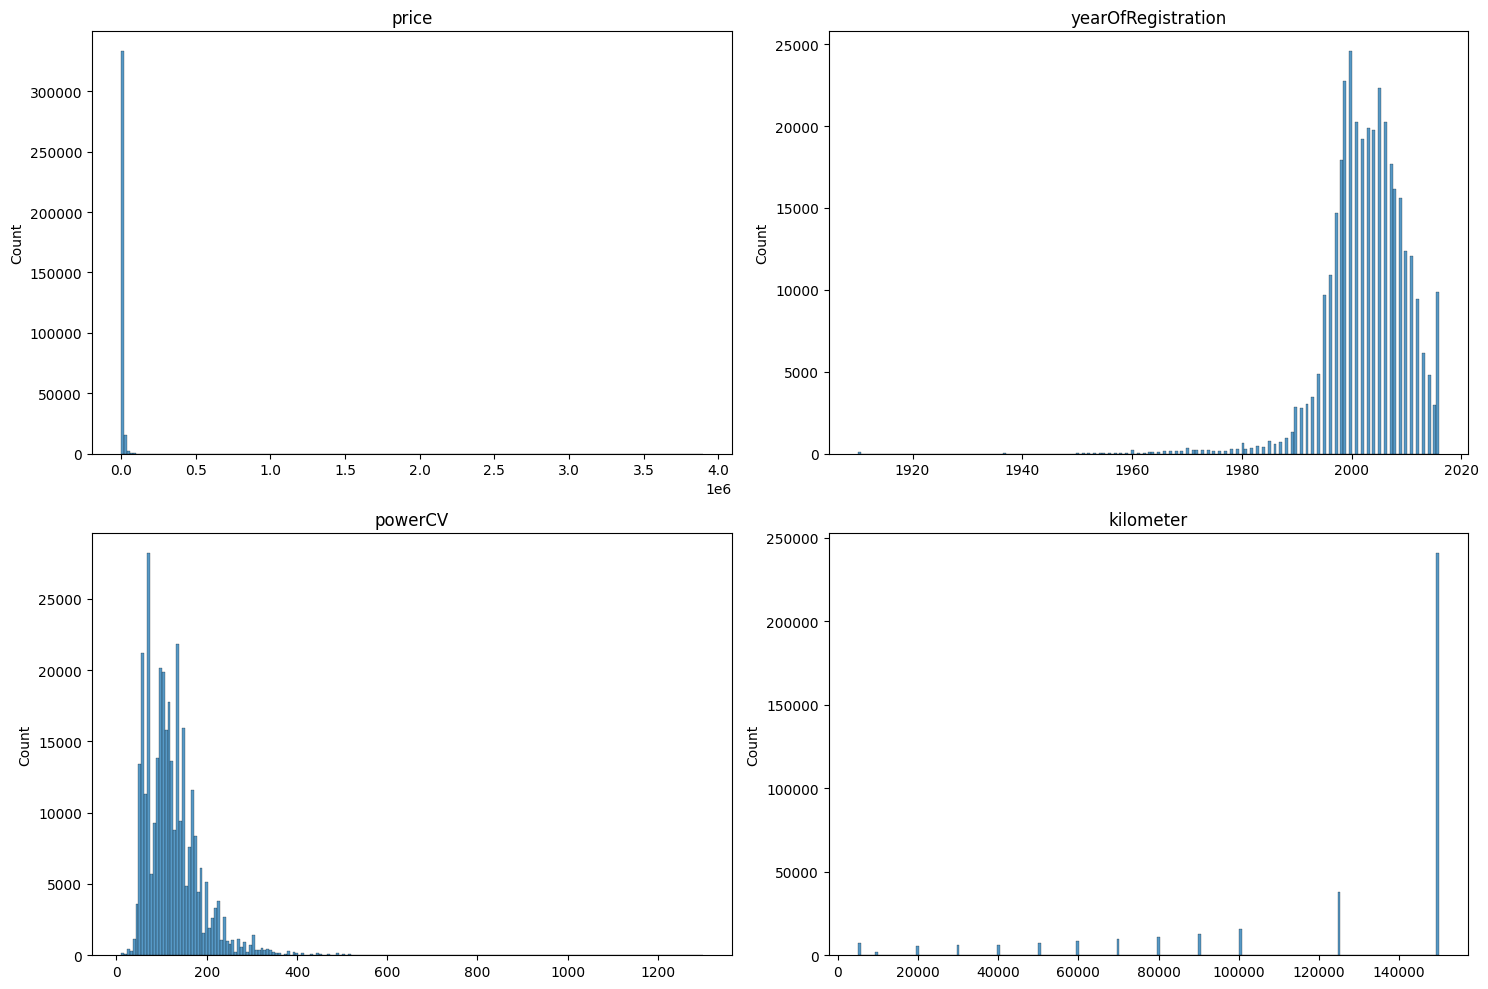

In [113]:
plot_numericas(df, nbins=200)

* Vemos que la mayoría de vehículos se distribuyen en el rango de precios más bajo, pero algunas unidades tienen precios muy altos, que posiblemente sean de lujo.

* En cuanto al año, la mayoría son de los 2000-2010, pero se extiende hacia el presente y lentamente hacia las décadas pasadas.

* En potencia pasa algo parecido al precio, la mayoría se mueven en el rango de 50 a 400 CV.

* En kilómetros vemos que los valores parecen discretos, por lo que puede ser que se correspondan con categorías agrupadas.

In [114]:
# Lo comprobamos
df['kilometer'].unique()

array([150000, 125000,  90000,  40000,  30000,  70000,   5000, 100000,
        60000,  20000,  80000,  50000,  10000])

Efectivamente son categorías pero lo vamos a dejar como numérico ya que medidas como la media o la mediana tienen sentido para nosotros.

---

Para las categóricas seleccionamos, solamente las columnas que nos interesan y que tengan sentido

In [115]:
df_cat.describe().T

,count,unique,top,freq
seller,371528,2,private,371525
offerType,371528,2,offer,371516
abtest,371528,2,test,192585
vehicleType,237765,7,small car,80023
gearbox,351319,2,manually,274214
model,351044,251,golf,30070
monthOfRegistration,333853.0,12.0,3.0,36170.0
fuelType,338142,7,petrol,223857
brand,371528,40,volkswagen,79640
notRepairedDamage,299468,2,no,263182


In [116]:
df_cat_filtered = df_cat[['seller', 'offerType', 'abtest', 'vehicleType', 'gearbox', 'monthOfRegistration', 'fuelType', 'notRepairedDamage']]

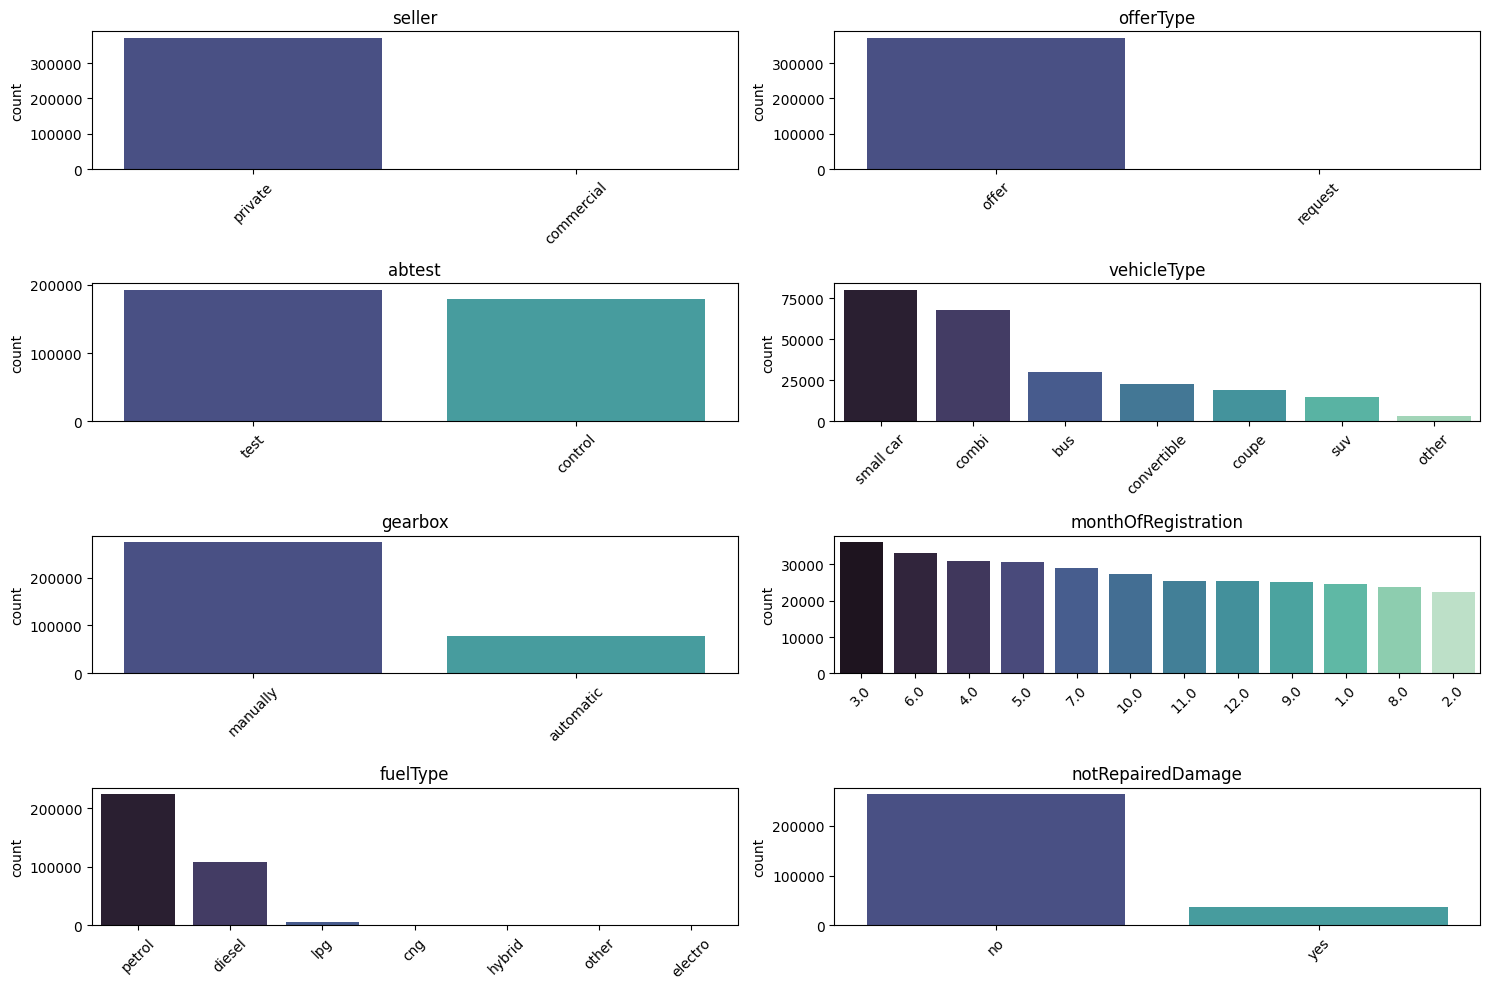

In [117]:
plot_categoricas(df_cat_filtered)

* `Seller`: la grandísima mayoría de vehículos son de particulares, lo cual es razonable en el mercado de segunda mano.

* `offerType`: la mayoría es offer y no request, lo que también tiene sentido ya que las subastas son mucho menos frecuentes.

* `abtest`: el grupo de test es ligeramente más grande, aunque casi iguales. Tiene sentido ya que suele ser conveniente que las muestras sean iguales.

* `vehicleType`: preferencia clara por coches pequeños y combi, seguidos a distancia por buses. Modelos de estilo, como convertibles y coupes, son menos comunes, y los SUVs y vehículos de la categoría "otros" son los menos frecuentes, reflejando una demanda alta de vehículos prácticos y familiares sobre opciones especializadas o de lujo.

* `gearbox`: los manuales dominan sobre los automáticos. Esto tiene sentido ya que los automáticos son más recientes y por lo tanto existen menos en el mercado de segunda mano.

* `monthOfRegistration`: se aprecia una distribución bastante uniforme, aunque con preferencia por algunos meses como marzo, junio, abril y mayo.

* `fuelType`: claramente dominan diesel y gasolina, con preferencia de gasolina.

* `notRepairedDamage`: la mayoría de coches no tienen daños sin reparar, aunque unos pocos sí. Tiene sentido ya que es mucho más sencillo vender un vehículo sin daños, aunque en ocasiones, si no se puede hacer frente a la reparación es frecuente que se recurra a la otra opción.

Vamos a ver por separado las marcas

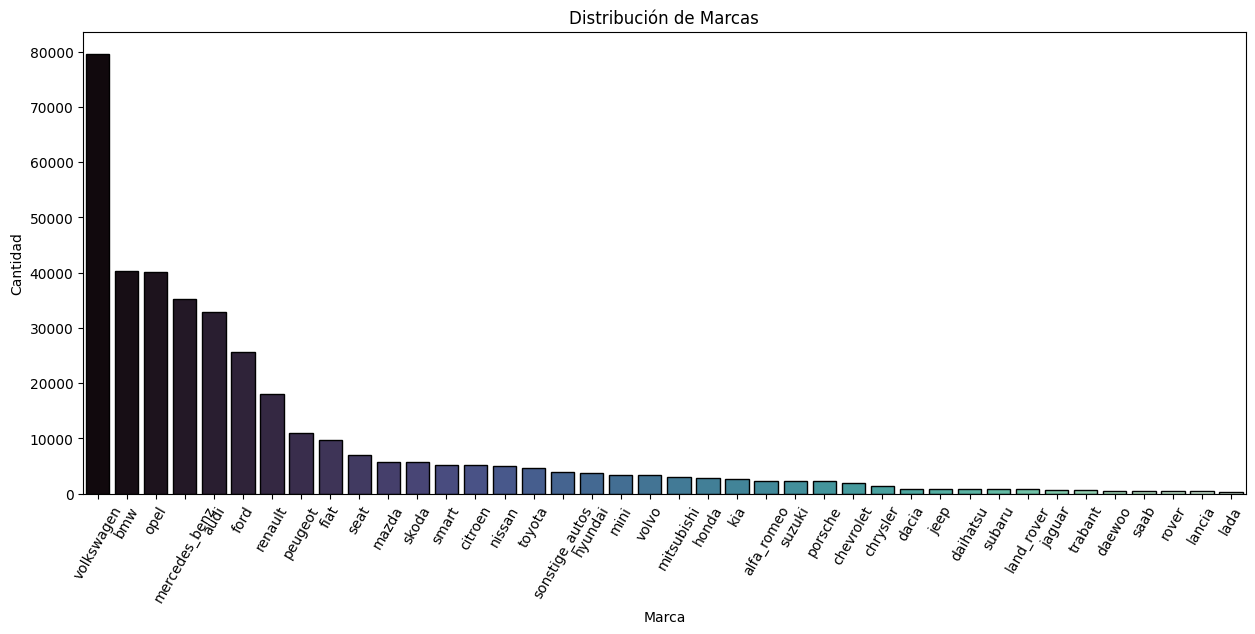

In [118]:
plt.figure(figsize=(15, 6))

# Ordenar las marcas por su frecuencia
order = df['brand'].value_counts().index

# Crear el countplot con una paleta de color
sns.countplot(data=df, x='brand', palette='mako', order=order, edgecolor='black')

# Agregar etiquetas y título
plt.title("Distribución de Marcas")
plt.xlabel("Marca")
plt.ylabel("Cantidad")

# Rotar las etiquetas del eje x si hay muchas categorías
plt.xticks(rotation=60)

# Mostrar el gráfico
plt.show()

Volkswagen domina claramente el mercado seguido por BMW y Opel. El resto de marcas poco a poco disminuyen su presencia.

---

### Relación entre numéricas y categóricas

In [119]:
df['price'].nunique()

5447

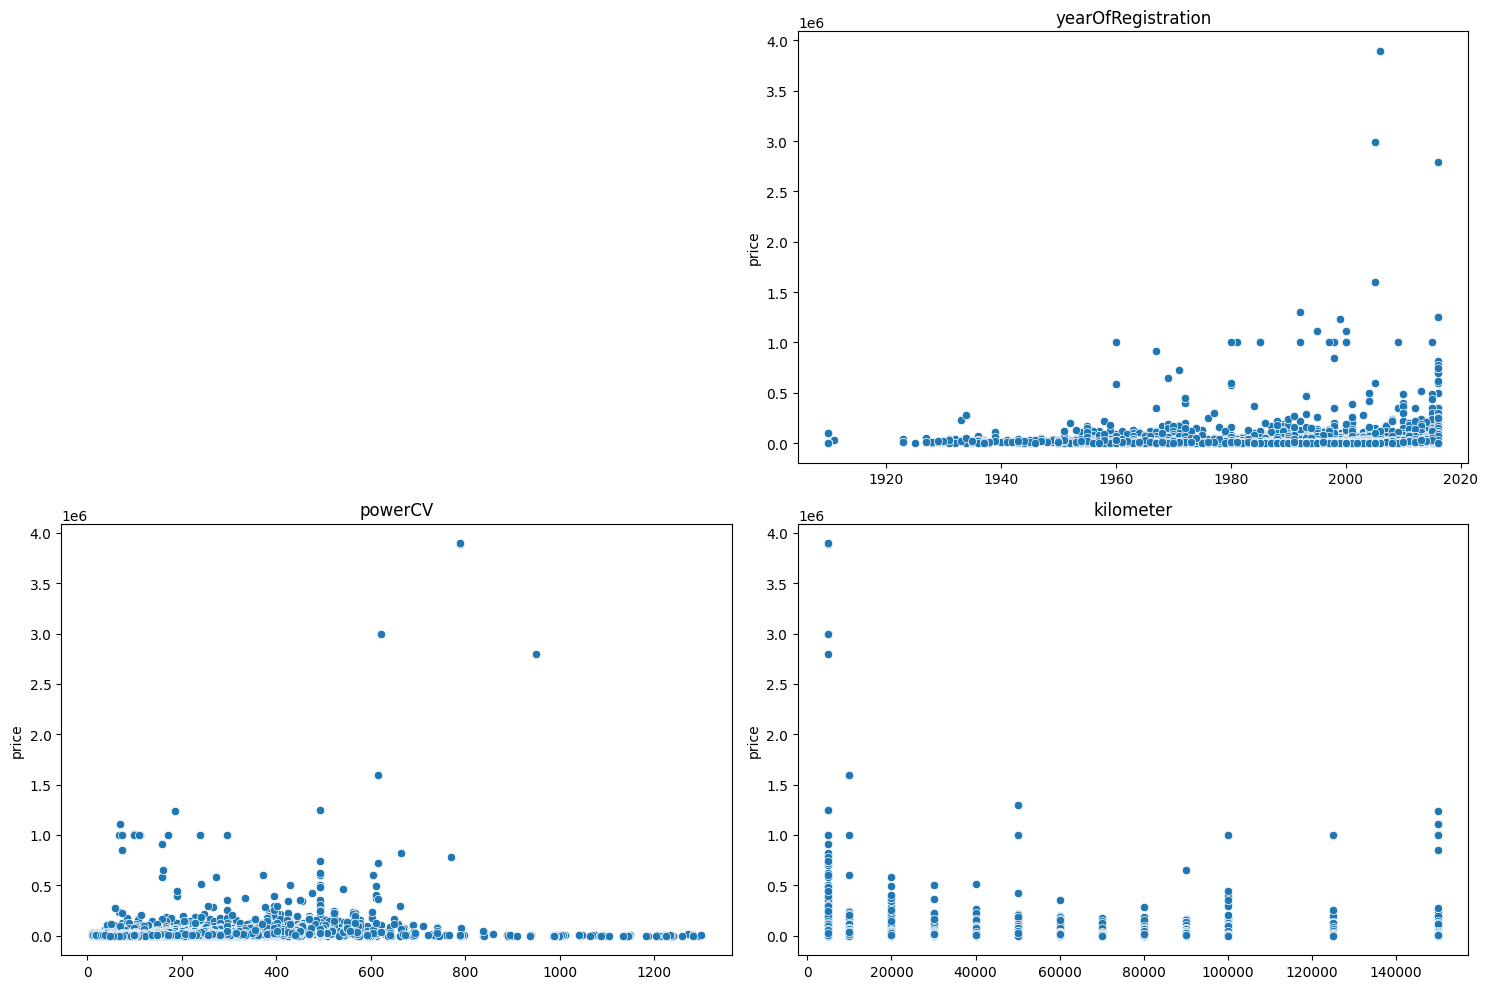

In [120]:
relacion_vr_numericas(df, "price")

No se ve nada en estos gráficos más allá de que los km son una categoría como hemos comentado anteriormente

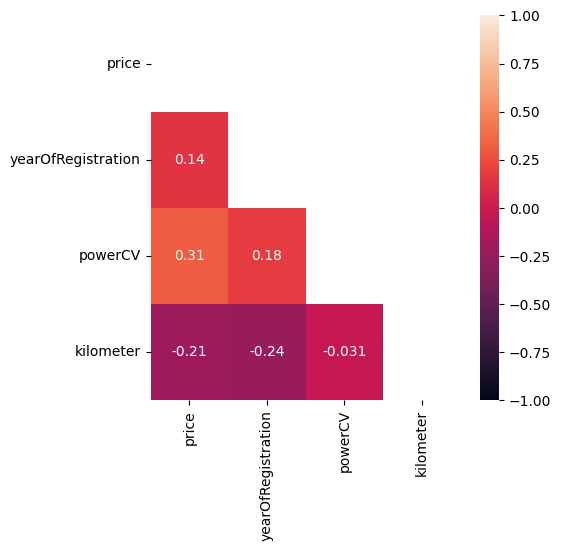

In [121]:
plot_matriz_correlacion(df)

En el mapa de calor sí vemos que hay una correlación moderada entre el precio y la potencia. Tiene sentido ya que vehículos más potentes tienden a ser más costosos, aunque un vehículo más caro puede serlo por otros motivos.

---

### Outliers

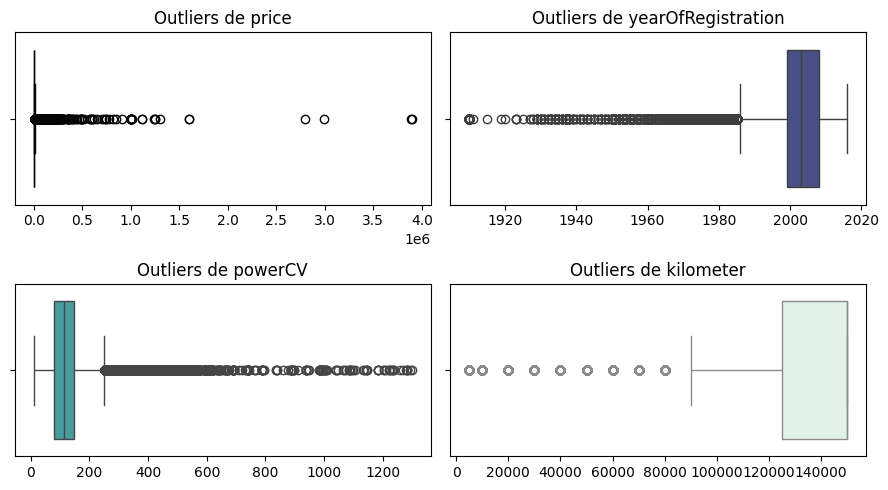

In [122]:
detectar_outliers(df, 'price')

De nuevo apreciamos el carácter discreto de la variable de km. De igual forma se ven las entradas de valores atípicos en cuanto a precio y potencia.

---

### Gestión de nulos

In [123]:
# Imputación de nulos usando métodos estadísticos
# -----------------------------------------------------------------------
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

In [124]:
# Duplicados
df.duplicated().sum()

19041

Hay 19041 duplicados, nos los cargamos

In [125]:
# Eliminamos duplicados
df.drop_duplicates(inplace=True)
df.reset_index(inplace=True, drop=True)
df.duplicated().sum()

0

`KNNImputer`

In [126]:
# Redefinimos el df_num. Importante que no se nos olvide el reset_index() para evitar problemas de concatenado
df_num = separar_df(df)[0].reset_index(drop=True)

In [127]:
# Excluimos la variable respuesta
df_predictoras = df_num.drop(columns=["price"])

# Creamos el objeto KNNImputer con 5 vecinos
imputer_knn = KNNImputer(n_neighbors=5)

# Aplicamos la imputación solo sobre las variables predictoras
knn_imputado = imputer_knn.fit_transform(df_predictoras)

In [128]:
# Convertimos el array resultante de la imputación a un DataFrame
df_predictoras_imputado = pd.DataFrame(knn_imputado, columns=df_predictoras.columns)

# Agregamos nuevamente la columna de la variable respuesta
df_final = pd.concat([df_predictoras_imputado, df_num["price"].reset_index(drop=True)], axis=1)

In [149]:
# Ahora le metemos las columnas que hemos limpiado al df original
df_knn = df.copy()
df_knn[df_final.columns] = df_final

In [150]:
# Vemos que hemos imputado los nulos de las numéricas
df_knn[df_final.columns].isnull().sum()

yearOfRegistration        0
powerCV                   0
kilometer                 0
price                 18033
dtype: int64

In [151]:
df.describe(include=np.number).T.round(2)

,count,mean,std,min,25%,50%,75%,max
price,334454.0,6238.56,18671.61,250.0,1350.0,3200.0,7500.0,3895000.0
yearOfRegistration,338182.0,2002.76,7.42,1910.0,1999.0,2003.0,2008.0,2016.0
powerCV,313975.0,124.58,63.89,10.0,79.0,114.0,148.0,1299.0
kilometer,352487.0,125618.58,40067.29,5000.0,125000.0,150000.0,150000.0,150000.0


In [152]:
df_knn.describe(include=np.number).T.round(2)

,count,mean,std,min,25%,50%,75%,max
price,334454.0,6238.56,18671.61,250.0,1350.0,3200.0,7500.0,3895000.0
yearOfRegistration,352487.0,2002.67,7.31,1910.0,1999.0,2003.0,2007.0,2016.0
powerCV,352487.0,124.42,61.10,10.0,85.0,114.0,148.0,1299.0
kilometer,352487.0,125618.58,40067.29,5000.0,125000.0,150000.0,150000.0,150000.0


Vemos alguna diferencia muy pequeña, por lo que nos sirve.

In [153]:
df_knn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352487 entries, 0 to 352486
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   seller               352487 non-null  object 
 1   offerType            352487 non-null  object 
 2   price                334454 non-null  float64
 3   abtest               352487 non-null  object 
 4   vehicleType          226054 non-null  object 
 5   yearOfRegistration   352487 non-null  float64
 6   gearbox              334379 non-null  object 
 7   powerCV              352487 non-null  float64
 8   model                332999 non-null  object 
 9   kilometer            352487 non-null  float64
 10  monthOfRegistration  317138 non-null  object 
 11  fuelType             320738 non-null  object 
 12  brand                352487 non-null  object 
 13  notRepairedDamage    284140 non-null  object 
dtypes: float64(4), object(10)
memory usage: 37.6+ MB


Vamos a imputar los nulos de las categóricas sustituyéndolas por `desconocido`

In [154]:
df_knn['vehicleType'].fillna('desconocido', inplace=True)
df_knn['gearbox'].fillna('desconocido', inplace=True)
df_knn['model'].fillna('desconocido', inplace=True)
df_knn['fuelType'].fillna('desconocido', inplace=True)
df_knn['brand'].fillna('desconocido', inplace=True)
df_knn['notRepairedDamage'].fillna('desconocido', inplace=True)

In [155]:
df_knn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352487 entries, 0 to 352486
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   seller               352487 non-null  object 
 1   offerType            352487 non-null  object 
 2   price                334454 non-null  float64
 3   abtest               352487 non-null  object 
 4   vehicleType          352487 non-null  object 
 5   yearOfRegistration   352487 non-null  float64
 6   gearbox              352487 non-null  object 
 7   powerCV              352487 non-null  float64
 8   model                352487 non-null  object 
 9   kilometer            352487 non-null  float64
 10  monthOfRegistration  317138 non-null  object 
 11  fuelType             352487 non-null  object 
 12  brand                352487 non-null  object 
 13  notRepairedDamage    352487 non-null  object 
dtypes: float64(4), object(10)
memory usage: 37.6+ MB


Vamos a guardarlo

In [156]:
df_knn.to_csv('datos/autorenew_knn.csv')

---

`IterativeImputer`

Hay `BayesianRidge`, `RandomForest`, `KNN` (igual al KNN anterior)

In [135]:
# Creamos el objeto IterativeImputer
imputer_iterative = IterativeImputer()

# Aplicamos la imputación solo sobre las variables predictoras
iterative_imputado = imputer_iterative.fit_transform(df_predictoras)

# Convertimos el array resultante de la imputación a un DataFrame
df_predictoras_imputado_iterative = pd.DataFrame(knn_imputado, columns=df_predictoras.columns)

# Agregamos nuevamente la columna de la variable respuesta
df_final_iterative = pd.concat([df_predictoras_imputado_iterative, df_num["price"].reset_index(drop=True)], axis=1)

In [136]:
# Ahora le metemos las columnas que hemos limpiado al df original
df_iterative = df.copy()
df_iterative[df_final_iterative.columns] = df_final_iterative

In [137]:
df.describe(include=np.number).T.round(2)

,count,mean,std,min,25%,50%,75%,max
price,334454.0,6238.56,18671.61,250.0,1350.0,3200.0,7500.0,3895000.0
yearOfRegistration,338182.0,2002.76,7.42,1910.0,1999.0,2003.0,2008.0,2016.0
powerCV,313975.0,124.58,63.89,10.0,79.0,114.0,148.0,1299.0
kilometer,352487.0,125618.58,40067.29,5000.0,125000.0,150000.0,150000.0,150000.0


In [138]:
df_iterative.describe(include=np.number).T.round(2)

,count,mean,std,min,25%,50%,75%,max
price,334454.0,6238.56,18671.61,250.0,1350.0,3200.0,7500.0,3895000.0
yearOfRegistration,352487.0,2002.67,7.31,1910.0,1999.0,2003.0,2007.0,2016.0
powerCV,352487.0,124.42,61.10,10.0,85.0,114.0,148.0,1299.0
kilometer,352487.0,125618.58,40067.29,5000.0,125000.0,150000.0,150000.0,150000.0


En este caso obtenemos resultados similares pero es más rápido